In [1]:
from pathlib import Path
from datetime import datetime as dt
import pandas as pd
import csv
import numpy as np
from scipy import ndimage
#from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print(tf.__version__)

1.7.0


In [3]:
def read_dataset(dataset):
    path="dataset/VQAMed2018"+dataset+"/VQAMed2018"+dataset+"-QA.csv"
    df =pd.read_csv(path, sep='\t', header=None, quoting=csv.QUOTE_NONE)
    if "Test" in dataset:
        df = df.rename(columns={0: 'id', 1: 'image_name', 2:"question"})
    else:
        df = df.rename(columns={0: 'id', 1: 'image_name', 2:"question", 3:"answer"})
    print(dataset+" data size=",len(df))
    images = []
    for i in df["image_name"]:

        fname = "dataset/VQAMed2018"+dataset+"/VQAMed2018"+dataset+"-images/"+i+".jpg"
        images.append(fname)
    if "Test" in dataset:
        return images, df["question"]
    else:
        return images, df["question"], df["answer"]


In [4]:
val_images, val_questions, val_answers = read_dataset("Valid")
train_images, train_questions, train_answers = read_dataset("Train")
#test_images, test_questions = read_dataset("Test")

Valid data size= 500
Train data size= 5413


In [5]:
id=0
print (train_images[id], "\n", train_questions[id], "\n",train_answers[id] )

dataset/VQAMed2018Train/VQAMed2018Train-images/rjv03401.jpg 
 what does mri show ? 
 lesion at tail of pancreas


dataset/VQAMed2018Valid/VQAMed2018Valid-images/ATM-02-80-g002.jpg
what does thorax ct show ?
regression in the infiltrations


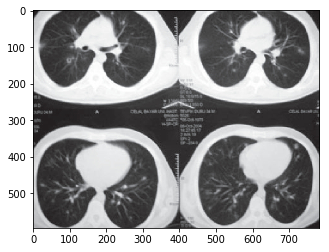

In [6]:
import matplotlib.image as mpimg
id=0
fname = val_images[id]
img=mpimg.imread(fname, format="jpg")
print (fname)
print(val_questions[id])
print(val_answers[id] )
plt.imshow(img)
plt.show()

In [7]:
img.shape

(595, 783, 3)

# Tensorflow

In [8]:
import os
import yaml
import sys
import math
import time
import argparse
import numpy as np
import tensorflow as tf
from random import shuffle
from shutil import copyfile
#from bleu import moses_multi_bleu
from time import strftime, localtime
from gensim.models.wrappers import FastText
from tensorflow.python.layers import core as layers_core

tf.set_random_seed(123)


In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession() # config=tf.ConfigProto(log_device_placement=True))

In [10]:
encoder_hidden_units = 300
decoder_hidden_units = encoder_hidden_units
output_dropout = 1.0
emb_size = 150
vocab_size = 100000
num_layers = 1
input_dropout = 0.9
epochs = 100
batch_size = 128
bidirectional = 1
residual = 0
attention = 0
attention_nodes = emb_size
beam_width = 5

In [11]:
vectors = 'dataset/vqa_vec150'

In [12]:
# Load FastText Model and create lookup embeddings
print("Load embeddings from: "+vectors)
all_model = FastText()
all_model = all_model.load_fasttext_format(vectors)
all_word_vectors = all_model.wv
embeddings = np.array([all_model[k] for k in all_word_vectors.vocab.keys()])

# Add PAD, EOS and UNK to the word embeddings
pre = np.concatenate((np.ones(emb_size)*-1, np.ones(emb_size), np.zeros(emb_size)))
all_vocab_size = len(all_word_vectors.vocab)
embeddings = np.reshape(np.insert(embeddings, 0, pre), (all_vocab_size+3, emb_size))
wor2tok = {'PAD': 0, 'EOS': 1, 'UNK': 2}
tok2wor = {0: 'PAD', 1: 'EOS', 2: 'UNK'}
ind = 3
for k in all_word_vectors.vocab.keys():
    wor2tok[k] = ind
    tok2wor[ind] = k
    ind += 1


Load embeddings from: dataset/vqa_vec150


In [13]:
tf_embeddings = tf.get_variable(name="emb", shape=embeddings.shape, dtype=tf.float32,
                                initializer=tf.constant_initializer(embeddings),
                                trainable=False)

encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32,
                                name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32,
                                name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32,
                                name='decoder_inputs')

decoder_train_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='decoder_targets_length')
batch_size_ph = tf.placeholder(tf.int32, [], name="bath_size")
input_dropout_ph = tf.placeholder(tf.float32, name="dropout")

encoder_vec_inputs = tf.nn.embedding_lookup(tf_embeddings, encoder_inputs)
decoder_vec_targets = tf.nn.embedding_lookup(tf_embeddings, decoder_targets)
decoder_vec_inputs = tf.nn.embedding_lookup(tf_embeddings, decoder_inputs)


### Encoder

In [14]:
# Bidirectional
if bidirectional == 1:
    forward_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units/2)
    backward_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units/2)
    forward_cell = tf.contrib.rnn.DropoutWrapper(
        forward_cell, input_keep_prob=input_dropout_ph, output_keep_prob=output_dropout)
    backward_cell = tf.contrib.rnn.DropoutWrapper(
        backward_cell, input_keep_prob=input_dropout_ph, output_keep_prob=output_dropout)

    biencoder_outputs, biencoder_final_state = tf.nn.bidirectional_dynamic_rnn(
          forward_cell, backward_cell, encoder_vec_inputs,time_major=False,
          dtype=tf.float32)

    outputs_concat = tf.concat([biencoder_outputs[0], biencoder_outputs[1]], 2)
i = 0
encoder_cells = []
for _ in range(num_layers):
    cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
    if bidirectional == 0 and i > 0:
        cell = tf.contrib.rnn.ResidualWrapper(cell)
    elif bidirectional == 1:
        cell = tf.contrib.rnn.ResidualWrapper(cell)
    cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=input_dropout_ph,
                                         output_keep_prob=output_dropout)
    encoder_cells.append(cell)
    i += 1

encoder_cell = tf.contrib.rnn.MultiRNNCell(encoder_cells)

# Encoder output and final state
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, (encoder_vec_inputs if bidirectional == 0 else outputs_concat),
    dtype=tf.float32, time_major=False, scope="plain_encoder"
)

Instructions for updating:
Use the retry module or similar alternatives.


In [15]:
def build_decoder( attention, encoder_outputs, encoder_final_state, helper, beam_size, reuse):
    with tf.variable_scope("decoder", reuse=reuse):
        if beam_size > 1:
            encoder_outputs = tf.contrib.seq2seq.tile_batch(
                           encoder_outputs,
                           multiplier=beam_size)

            encoder_final_state = tf.contrib.framework.nest.map_structure(
                        lambda s: tf.contrib.seq2seq.tile_batch(s, beam_size),
                        encoder_final_state)

        decoder_cells = []
        for _ in range(num_layers):
            cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)
            cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=input_dropout_ph,
                                                output_keep_prob=output_dropout)
            decoder_cells.append(cell)
        initial_state = [state for state in encoder_final_state]
        # Attention
        if attention == 1:

            attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                                    decoder_hidden_units,
                                    encoder_outputs,
                                    name="BahdanauAttention")

            decoder_cells[-1]= tf.contrib.seq2seq.AttentionWrapper(
                                    decoder_cells[-1],
                                    attention_mechanism,
                                    attention_layer_size=emb_size,
                                    name="AttentionWrapper")

            initial_state[-1] = decoder_cells[-1].zero_state(
                                    batch_size=batch_size_ph * beam_size,
                                    dtype=tf.float32)

        initial_state = tuple(initial_state)
        projection_layer = layers_core.Dense(vocab_size, use_bias=False)
        decoder_cell = tf.contrib.rnn.MultiRNNCell(decoder_cells)

        if helper !=None:
            if helper=="greedy":
                helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                        tf_embeddings,
                        tf.fill([batch_size_ph], 1),
                        1)
            else:
                helper = tf.contrib.seq2seq.TrainingHelper(
                                        decoder_vec_inputs,
                                        decoder_train_length,
                                        name = "TrainingHelper")

            print("Helper =",helper)
            decoder_outputs = tf.contrib.seq2seq.BasicDecoder(
                                cell = decoder_cell,
                                helper = helper,
                                initial_state = initial_state,
                                output_layer=projection_layer)

        else:
            decoder_outputs= tf.contrib.seq2seq.BeamSearchDecoder(
                                    cell=decoder_cell,
                                    embedding=tf_embeddings,
                                    start_tokens= tf.fill([batch_size_ph], 1),
                                    end_token=1,
                                    beam_width=beam_size,
                                    initial_state=initial_state,
                                    output_layer=projection_layer,
                                    length_penalty_weight=0.0)

        decoder_outputs,_,_ = tf.contrib.seq2seq.dynamic_decode(
                                    decoder_outputs,
                                    maximum_iterations=30)
    return decoder_outputs


In [16]:
train_decoder = build_decoder(
                    attention,
                    encoder_outputs,
                    encoder_final_state,
                    helper = "train",
                    beam_size = 1,
                    reuse = False)

greedy_decoder = build_decoder(
                    attention,
                    encoder_outputs,
                    encoder_final_state,
                    helper = "greedy",
                    beam_size = 1,
                    reuse = True)

beam_decoder = build_decoder(
                    attention,
                    encoder_outputs,
                    encoder_final_state,
                    helper = None,
                    beam_size = beam_width,
                    reuse = True)

Helper = <tensorflow.contrib.seq2seq.python.ops.helper.TrainingHelper object at 0x7fd317de9128>
Helper = <tensorflow.contrib.seq2seq.python.ops.helper.GreedyEmbeddingHelper object at 0x7fd30dcb1898>


In [17]:
train_translations= train_decoder.sample_id
greedy_translations = greedy_decoder.sample_id
beam_translations = beam_decoder.predicted_ids
beam_scores = beam_decoder.beam_search_decoder_output.scores
output = train_decoder.rnn_output

In [18]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=decoder_targets, logits=output))
train_op = tf.train.AdamOptimizer().minimize(loss)

### Inference

In [19]:
def test(sess, sent, id, actual):
    
    X = [sent.strip()]
    X_tok = [[word for word in x.lower().strip().split()] for x in X]

    ei = np.array([[wor2tok[w] if w in wor2tok.keys() else wor2tok['UNK'] for w in x]
                + [wor2tok['EOS']] for x in X_tok]).T

    greedy_out, beam_out, beam_score = sess.run(
                [greedy_translations, beam_translations, beam_scores],
                feed_dict={encoder_inputs: ei.T, input_dropout_ph: 1.0, batch_size_ph :1})

    greedy_sent= " ".join([tok2wor[i] for i in greedy_out[0][:-1]])

    beam_sents = [ [tok2wor[j] for j in beam_out[0].T[i] if j!=-1 and j!=1] for i in range(beam_width)]
    beam_sents_scores = [beam_score[0].T[i] for i in range(beam_width)]
    list_of_preds = [" ".join(r) for r in beam_sents]
    if id < 30:
        print("Sentence: "+ sent)
        print("Actual: "+actual)
        print("Greedy predicted: "+ greedy_sent)
       # printf("Beam predicted: "+ list_of_preds)
        for i in range(len(list_of_preds)):
           printf("Beam predicted #"+str(i+1)+": "+ list_of_preds[i])
    else:
        sys.stdout.write('\r')
        sys.stdout.write("testing: " + str(id) + " out of " + str(len(test_src)))
        sys.stdout.flush()

    return greedy_sent, list_of_preds[0], list_of_preds[-1]


### Feeding

In [26]:
def next_feed(batch_size, i, isTrain):

    if isTrain:
        X = train_questions[batch_size*i:batch_size*(i+1)]
        Y = train_answers[batch_size*i:batch_size*(i+1)]

    src_max = 0 
    trg_max = 0
    sentence_lengths=[]

    for x, y in zip(X, Y):
        if len(y.split()) > trg_max:
            trg_max = len(y.split())
        if len(x.split()) > src_max:
            src_max = len(x.split())

    sentence_lengths= [trg_max+1 for s in range(batch_size)]
    sentence_lengths= np.array(sentence_lengths)

    X_tok = [[word for word in x.lower().strip().split()] for x in X]
    Y_tok = [[word for word in y.lower().strip().split()] for y in Y]

    ei = np.array([[wor2tok[w] for w in x] + [wor2tok['EOS']] +
                   [wor2tok['PAD']] * (src_max - len(x)) for x in X_tok]).T
    di = np.array([[wor2tok['EOS']] +
                    [wor2tok[w] if wor2tok[w] < vocab_size else wor2tok['UNK'] for w in x]
                    + [wor2tok['PAD']] * (trg_max - len(x)) for x in Y_tok]).T
    dt = np.array([[wor2tok[w] if wor2tok[w] < vocab_size else wor2tok['UNK']
                    for w in x] + [wor2tok['EOS']] +
                    [wor2tok['PAD']]*(trg_max - len(x)) for x in Y_tok]).T


    return {
        encoder_inputs: ei.T,
        decoder_inputs: di.T,
        decoder_targets: dt.T,
        input_dropout_ph: input_dropout,
        batch_size_ph : batch_size,
        decoder_train_length: sentence_lengths
    }, X, Y


In [ ]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables(), max_to_keep=100)

In [ ]:
print("Start training")
for iteration in range(epochs):
    start=time.time()
    avg_cost = 0.
    total_batch = int(len(train_questions)/batch_size)
    for i in range(total_batch):
        fd, X, Y = next_feed(batch_size, i, True)
        _, cost = sess.run([train_op, loss], feed_dict=fd)
        avg_cost += cost/total_batch
        if i > 0 and i % 100 == 0:
            print("Partial Iteration " + str(i) + "/" + str(total_batch) +
                  " :  "+ '%04d' % (iteration + 1)+ " cost= "+ "{:.9f}".format(avg_cost))
    end=time.time()
    
    print("Training Latency: "+str(round((end-start),2))+" seconds"+"\n")
    if (iteration+1) %5 == 0  and iteration > 0:
        print("\nTesting...")
        out = [test(sess, val_questions[i], i, val_answers[i]) for i in range(len(val_questions))]
        ref_arr = np.array(val_answers)

        greedies = np.array([i[0] for i in out])
        first_beams = np.array([i[1] for i in out])
        last_beams = np.array([i[2] for i in out])

        try:
            bleu_geedy = moses_multi_bleu(greedies, ref_arr)
            bleu_first_beam = moses_multi_bleu(first_beams, ref_arr)
            bleu_last_beam = moses_multi_bleu(last_beams, ref_arr)

            print("bleu test  (greedy):     " + str(bleu_geedy))
            print("bleu test  (first beam): " + str(bleu_first_beam))
            print("bleu test  (last beam):  " + str(bleu_last_beam))

            with open(saver_folder + "/bleu.txt", "a") as f:
                f.write("Test " + str(iteration+1) + "\n")
                f.write("- bleu test  (greedy)    : " + str(bleu_geedy)+"\n")
                f.write("- bleu test  (first beam): " + str(bleu_first_beam)+"\n")
                f.write("- bleu test  (last beam) : " + str(bleu_last_beam)+"\n\n")
        except ZeroDivisionError:
            print ("Exception ZeroDivisionError: float division by zero !")

        saver.save(sess, saver_folder+'/translate'+str(iteration+1))
        print("Model Saved!")
    print("Iteration: "+ '%04d' % (iteration + 1)+ " cost= "+ "{:.9f}".format(avg_cost))
    tf.summary.scalar('loss', avg_cost)

print("Tuning Completed!")

Start training
Training Latency: 1694.16 seconds

Iteration: 0001 cost= 5.122643034
Training Latency: 1629.62 seconds

Iteration: 0002 cost= 2.000358982
